# Generating a super-resolved output

Using the pre-trained, or any other trained model, we can easily generate super-resolved outputs by passing the low-resolution images to the model.

## Loading the dataset
First we load the dataset. Make sure to edit the parameters to match the trained model (number of revisits, low resolution bands, etc.).

In [1]:
%load_ext autoreload
%autoreload 2
from multiprocessing import Manager
from src.datasets import load_dataset_JIF
import pandas as pd

multiprocessing_manager = Manager()
list_of_aois = list(
    pd.read_csv("pretrained_model/stratified_train_val_test_split.csv", index_col=1).index
)
kws = dict(
    input_size=(160, 160),
    output_size=(500, 500),
    chip_size=(50, 50),
    revisits={"lr": 8, "lrc": 8, "hr": 1, "hr_pan": 1},
    normalize_lr=True,
    sclcolor=False,
    lrc_filter_values=None,
    lrc_filter_thres=0.9,
    root="dataset/",
    multiprocessing_manager=multiprocessing_manager,
    list_of_aois=list_of_aois,
    calculate_median_std=False,
    radiometry_depth=12,
    lr_bands="all",
    num_workers=0,
    max_epochs=-1,
)

dataloaders = load_dataset_JIF(**kws)
dataset = dataloaders["val"].dataset
print(len(dataset))
print(dataset[0]["lr"].shape)
print(dataset[0]["lrc"].shape)
print(dataset[0]["hr"].shape)


Using all LR bands.
Shuffling the dataset splits using 42
Train set size: 28287
Val set size: 3528
Test set size: 3528
3528
torch.Size([8, 12, 50, 50])
torch.Size([8, 1, 50, 50])
torch.Size([1, 3, 156, 156])


## Loading the model

We also need to load the model, pass the inputs forward and then visualise the output.  

Please select whether to use the CPU or GPU by uncommenting the lines below.  
By default, a GPU will be used if available, if not, the CPU will be used.

In [2]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Uncomment to use the CPU
# device = 'cpu'

# Uncomment to use the GPU
# device = 'cuda'

print('Using device:', device)
print()

Using device: cuda



In [3]:
from src.datasources import S2_ALL_12BANDS
from src.modules import BicubicUpscaledBaseline
from src.plot import showtensor
from src.lightning_modules import LitModel
from torchvision.utils import make_grid
def load_model(checkpoint, device):
    """ Loads a model from a checkpoint.

    Parameters
    ----------
    checkpoint : str
        Path to the checkpoint.

    Returns
    -------
    model : lightning_modules.LitModel
        The model.
    """    
    model = LitModel.load_from_checkpoint(checkpoint).eval()
    return model.to(device)

def get_next_x_y_from_batch(dataloaders, device, split="val"):
    """ Get the next x (LR) and y (HR) from the dataloader.

    Parameters
    ----------
    dataloaders : dict of {str: torch.utils.data.DataLoader}
        The dictionary of dataloaders ('train', 'val', 'test'), as returned by load_dataset_JIF.
    split : str, optional
        The split to use. The default is "val".

    Returns
    -------
    x, y: torch.Tensor, torch.Tensor
        The next low-resolution and high-resolution images.

    Raises
    ------
    ValueError
        If the split is not train, val or test.
    """    
    if not split in ["train", "val", "test"]:
        raise Exception(f"Split needs to be train, val or test.")
    batch = next(iter(dataloaders["val"]))
    y = batch["hr"].to(device)
    x = batch["lr"].to(device)
    return x, y


def bias_adjust(y_hat, y):
    """ Adjust the bias of the output of the model.

    Parameters
    ----------
    y_hat : torch.Tensor
        The output of the model (super-resolved image).
    y : torch.Tensor
        The ground truth (high-resolution image).

    Returns
    -------
    y_hat : torch.Tensor
        The output of the model (super-resolved image) with bias adjusted.
    """    
    b = (y - y_hat).mean(dim=(-1, -2), keepdim=True)
    return y_hat + b


def run_inference(x, y, checkpoint_path, device):
    """ Run inference given a low-resolution input, the high-resolution ground truth and a checkpoint path.

    Parameters
    ----------
    x : torch.Tensor
        The low-resolution input.
    y : torch.Tensor
        The high-resolution ground truth.
    checkpoint_path : str
        The path to the checkpoint.

    Returns
    -------
    y_hat : torch.Tensor
        The output of the model (super-resolved image).
    """    
    model = load_model(checkpoint_path, device)
    y_hat = model(x)
    baseline = BicubicUpscaledBaseline(
        input_size=x.shape[-2:], chip_size=x.shape[-2:], output_size=y.shape[-2:], device=device
    )
    y_baseline = baseline(x)
    y_hat = bias_adjust(y_hat, y)
    y_baseline = bias_adjust(y_baseline, y)
    return y_hat, y_baseline


def preview_inference(x, y, y_hat, y_baseline):
    """ Preview the inference results.

    Parameters
    ----------
    x : torch.Tensor
        The low-resolution input.
    y : torch.Tensor
        The high-resolution ground truth.
    y_hat : torch.Tensor
        The output of the model (super-resolved image).
    y_baseline : torch.Tensor
        The low-resolution input upscaled (bicubic) to the high-resolution resolution.
    """    
    showtensor(
        make_grid(
            x[:, :, S2_ALL_12BANDS["true_color"]].cpu(),
            nrow=10,
            normalize=True,
            scale_each=True,
        ),
        figsize=5,
    )
    showtensor(
        make_grid(make_grid(torch.cat((y_hat, y_baseline), 1).cpu(), normalize=True), nrow=10, normalize=True, scale_each=True), figsize=5
    )
    showtensor(make_grid(y.cpu(), nrow=10, normalize=True, scale_each=True), figsize=5)

Lightning automatically upgraded your loaded checkpoint from v1.5.10 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file c:\Users\ori\Desktop\0 WORLDSTRAT\repo\pretrained_model\model.ckpt`
c:\Users\ori\mambaforge\envs\worldstrat\lib\site-packages\pytorch_lightning\utilities\parsing.py:262: UserWarning: Attribute 'backbone' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['backbone'])`.
  rank_zero_warn(
c:\Users\ori\mambaforge\envs\worldstrat\lib\site-packages\torch\nn\functional.py:3631: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  warnings.warn(


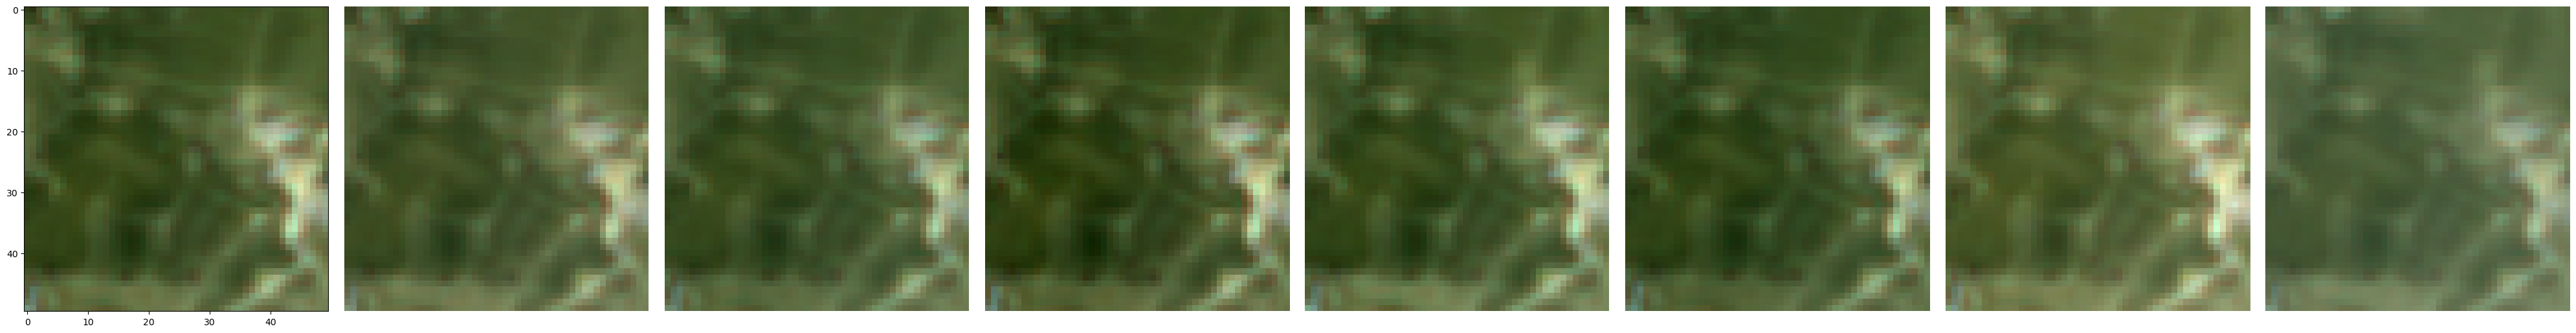

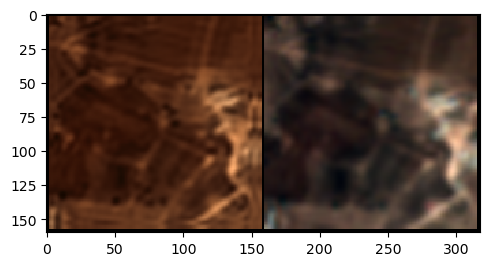

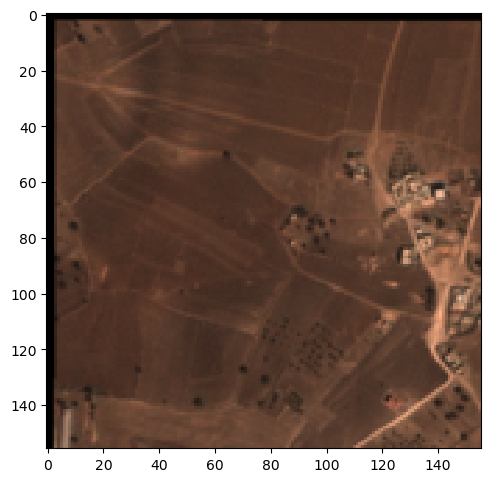

In [4]:
checkpoint_path = f"pretrained_model/model.ckpt"
x, y = get_next_x_y_from_batch(dataloaders, device)
y_hat, y_baseline = run_inference(x, y, checkpoint_path, device)
preview_inference(x, y, y_hat, y_baseline)